<a href="https://colab.research.google.com/github/gogosean/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/LS_DS6_113_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

X Variable: 
- predictor
- explanatory variable
- feature
- independent variable

Y Variable:
- predicted variable
- explained variable
- target
- dependent variable

In [0]:
import random
dir(random)  # Reminding ourselves what we can do here

In [0]:
import numpy as np
dir(np.random)

In [0]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [0]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(2500):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(7500):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users)

[User(purchased=True, time_on_site=234.23821121184804, mobile=True), User(purchased=False, time_on_site=416.74967043165196, mobile=False), User(purchased=True, time_on_site=241.16235696491248, mobile=True), User(purchased=True, time_on_site=411.8397511716441, mobile=False), User(purchased=False, time_on_site=75.3312437333078, mobile=True), User(purchased=False, time_on_site=93.24590384559897, mobile=True), User(purchased=True, time_on_site=54.67000083040827, mobile=True), User(purchased=False, time_on_site=279.3140832055173, mobile=True), User(purchased=True, time_on_site=229.23328152435343, mobile=False), User(purchased=True, time_on_site=465.0029791699171, mobile=False), User(purchased=False, time_on_site=455.72906760129246, mobile=False), User(purchased=False, time_on_site=141.6111280973264, mobile=True), User(purchased=True, time_on_site=285.35942886903064, mobile=False), User(purchased=True, time_on_site=14.100147867049577, mobile=True), User(purchased=True, time_on_site=16.043327

In [0]:
!pip freeze

In [0]:
!pip install pandas==0.23.4

In [0]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

NameError: ignored

In [0]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.044994865148051,5.062435108072614,5.081736106061906,5.147168837994579,5.147852633953633,5.181521126416139,5.192011119174508,5.239928257590038,5.294134949849264,5.322147454995715,5.371582246024794,5.4134278362258765,5.457561412701911,5.474423030467426,5.483611825523421,5.492524346914686,5.506895922796098,5.5382812598547195,5.557848585705835,5.578142797716911,5.587377879226204,5.597985219737237,5.738161762100628,5.815447471677413,5.843778050573451,5.881855502465893,5.911128615440704,5.990430058173292,5.997137937344851,6.036390204323782,6.038064630611662,6.065961298933825,6.087590808345073,6.089576580614708,6.119826808305413,6.152072814783044,6.191639713714356,6.318281102905164,6.335649188560762,6.344313706732407,...,589.651658858645,590.1658559233597,591.033301527137,591.4395724932466,591.7635906834395,592.0367870470677,592.089225969135,592.142641099694,592.489530406305,592.7765718288961,592.9969172814883,593.034197303646,593.12218192242,593.1228736552924,593.1455882718295,593.1888091960789,593.4197879096624,593.620255277723,593.6270584651228,593.7169285358892,593.9029955091976,593.9694186787951,594.0313109656453,594.4252956832955,594.5557663715208,595.1450970485517,595.2675413230328,595.7374449054556,596.2076339647804,597.1595093491238,597.4259144831892,597.4615806388664,597.9446552931173,598.1787038307767,598.3730235592137,598.439470210336,598.5544844569342,599.2912534979891,599.6472736067761,599.8792293115033
purchased,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,1,1,1,1,0,1,0,0,1,1,0,0,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,0,0,1,...,1,1,1,1,0,1,1,0,0,0,1,1,1,1,0,1,1,0,0,1,0,0,1,0,1,1,0,1,0,0,0,0,1,1,0,0,1,1,0,1
True,0,0,0,0,1,0,1,1,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,1,0,...,0,0,0,0,1,0,0,1,1,1,0,0,0,0,1,0,0,1,1,0,1,1,0,1,0,0,1,0,1,1,1,1,0,0,1,1,0,0,1,0


In [0]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 6)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.45, 104.184]","(104.184, 203.323]","(203.323, 302.462]","(302.462, 401.601]","(401.601, 500.74]","(500.74, 599.879]"
purchased,,,,,,
False,2059,1800,1598,283,282,229
True,875,1065,1285,168,174,182


In [0]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.45, 104.184]","(104.184, 203.323]","(203.323, 302.462]","(302.462, 401.601]","(401.601, 500.74]","(500.74, 599.879]"
purchased,,,,,,
False,0.701772,0.628272,0.554284,0.627494,0.618421,0.557178
True,0.298228,0.371728,0.445716,0.372506,0.381579,0.442822


In [0]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.6976,0.600933
True,0.3024,0.399067


In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

ct = pd.crosstab(user_data['mobile'], [user_data['purchased'], time_bins], normalize='index')
ct

purchased              False        ...                    True 
time_on_site (4.45, 104.184]        ...        (500.74, 599.879]
mobile                              ...                         
False               0.135200        ...                   0.0728
True                0.229467        ...                   0.0000

[2 rows x 12 columns]

In [0]:
type(ct)

pandas.core.frame.DataFrame

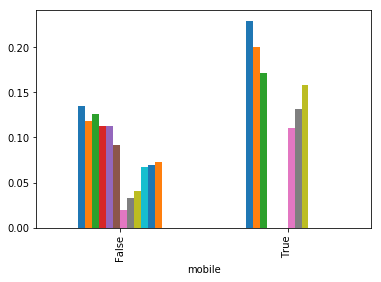

In [0]:
ct.plot(kind='bar', legend=False);

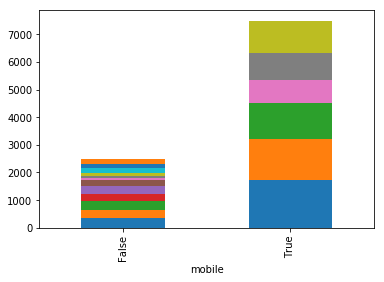

In [0]:
ct = pd.crosstab(user_data['mobile'], [user_data['purchased'], time_bins])

ct.plot(kind='bar', stacked=True, legend=False);

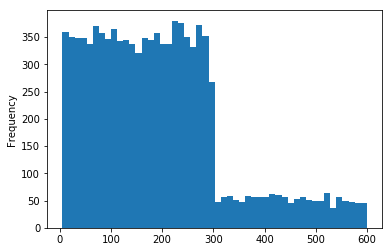

In [0]:
user_data['time_on_site'].plot.hist(bins=50);

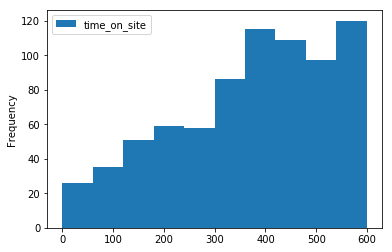

In [0]:
user_data[(user_data['mobile']==False) & (user_data['purchased']==True)].plot.hist()

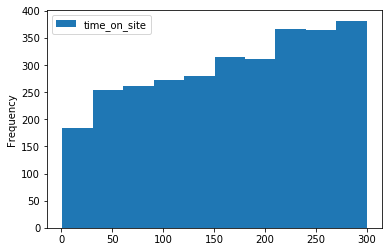

In [0]:
user_data[(user_data['mobile']==True) & (user_data['purchased']==True)].plot.hist()

In [0]:
pt = pd.pivot_table(user_data, values='purchased', index=time_bins)
pt

,purchased
time_on_site,
"(4.45, 104.184]",0.298228
"(104.184, 203.323]",0.371728
"(203.323, 302.462]",0.445716
"(302.462, 401.601]",0.372506
"(401.601, 500.74]",0.381579
"(500.74, 599.879]",0.442822


## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
# TODO - your code here
# Use what we did live in lecture as an example
import pandas as pd
df_url='https://raw.githubusercontent.com/gogosean/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module3-databackedassertions/persons.csv'
df = pd.read_csv(df_url)
df.head()
# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

,Unnamed: 0,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182


In [0]:
#df.head()
#print (df.age)
#Unnamed: 0  age  weight  exercise_time
weight_bins = pd.cut(df['weight'], 6)
age_bins = pd.cut(df['age'], 6)
exercise_bins = pd.cut(df['exercise_time'], 6)

In [0]:
import pandas as pd
ct = pd.crosstab(weight_bins,age_bins, normalize='index')
ct


age,"(17.938, 28.333]","(28.333, 38.667]","(38.667, 49.0]","(49.0, 59.333]","(59.333, 69.667]","(69.667, 80.0]"
weight,,,,,,
"(99.854, 124.333]",0.190476,0.238095,0.166667,0.170068,0.102041,0.132653
"(124.333, 148.667]",0.187500,0.161184,0.210526,0.164474,0.157895,0.118421
"(148.667, 173.0]",0.189723,0.173913,0.154150,0.130435,0.173913,0.177866
"(173.0, 197.333]",0.136905,0.166667,0.130952,0.166667,0.190476,0.208333
"(197.333, 221.667]",0.140845,0.154930,0.147887,0.154930,0.204225,0.197183
"(221.667, 246.0]",0.128205,0.102564,0.128205,0.025641,0.230769,0.384615


In [0]:
ct2= pd.crosstab(weight_bins,exercise_bins, normalize='index')
ct2

exercise_time,"(-0.3, 50.0]","(50.0, 100.0]","(100.0, 150.0]","(150.0, 200.0]","(200.0, 250.0]","(250.0, 300.0]"
weight,,,,,,
"(99.854, 124.333]",0.115646,0.142857,0.173469,0.173469,0.156463,0.238095
"(124.333, 148.667]",0.121711,0.154605,0.088816,0.203947,0.207237,0.223684
"(148.667, 173.0]",0.146245,0.249012,0.193676,0.173913,0.166008,0.071146
"(173.0, 197.333]",0.279762,0.267857,0.244048,0.184524,0.023810,0.000000
"(197.333, 221.667]",0.366197,0.436620,0.183099,0.014085,0.000000,0.000000
"(221.667, 246.0]",0.871795,0.128205,0.000000,0.000000,0.000000,0.000000


In [0]:
ct3= pd.crosstab(age_bins,exercise_bins, normalize='index')
ct2

exercise_time,"(-0.3, 50.0]","(50.0, 100.0]","(100.0, 150.0]","(150.0, 200.0]","(200.0, 250.0]","(250.0, 300.0]"
weight,,,,,,
"(99.854, 124.333]",0.115646,0.142857,0.173469,0.173469,0.156463,0.238095
"(124.333, 148.667]",0.121711,0.154605,0.088816,0.203947,0.207237,0.223684
"(148.667, 173.0]",0.146245,0.249012,0.193676,0.173913,0.166008,0.071146
"(173.0, 197.333]",0.279762,0.267857,0.244048,0.184524,0.023810,0.000000
"(197.333, 221.667]",0.366197,0.436620,0.183099,0.014085,0.000000,0.000000
"(221.667, 246.0]",0.871795,0.128205,0.000000,0.000000,0.000000,0.000000


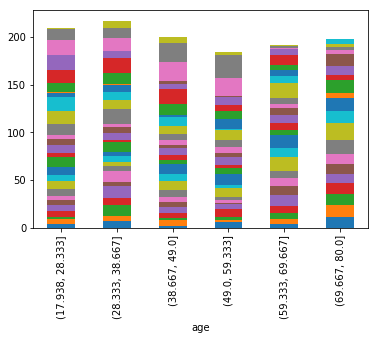

In [0]:
ctplot = pd.crosstab(age_bins, [exercise_bins, weight_bins])

ctplot.plot(kind='bar', stacked=True, legend=False);

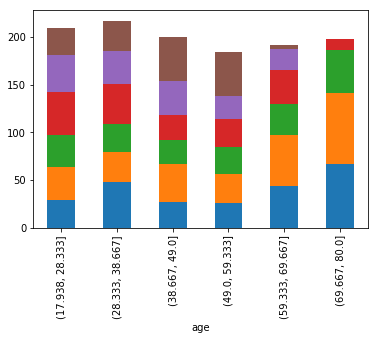

In [0]:
ctplot = pd.crosstab(age_bins, exercise_bins)

ctplot.plot(kind='bar', stacked=True, legend=False);

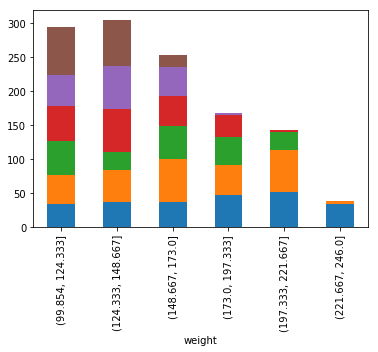

In [0]:
ctplot = pd.crosstab(weight_bins, exercise_bins)

ctplot.plot(kind='bar', stacked=True, legend=False);

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?**Ordinal and contiunous**
2.  What are the relationships between the variables? **exercise declines with age and wieight **
3.  Which relationships are "real", and which spurious? the relationship is complex, i would say the exercise being dependant on age and weight is not spurious


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)